<a href="https://colab.research.google.com/github/BDouchet/Spotify_dataset/blob/main/genre_classification/K_FOLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='16phKfXvRrwGbOJrNKpgbYnBnZG6icXFX'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('dataset.zip')

with ZipFile('dataset.zip', 'r') as zip:
   zip.extractall()
   print('Done')

df=pd.read_csv('dataset/Spotify_train_dataset.csv')

from sklearn.preprocessing import LabelEncoder

data=df.drop(labels=['type','id','uri','track_href','analysis_url','song_name'],axis=1)

genres=['Dark Trap', 'Underground Rap', 'Trap Metal', 'Emo', 'Rap', 'RnB', 'Pop', 'Hiphop', 'techhouse', 'techno',
'trance', 'psytrance', 'trap', 'dnb', 'hardstyle']

le = LabelEncoder()
le.classes_=genres
data['genre']=le.transform(data['genre'])

X=data[data.columns[:-1]].to_numpy()
Y=data['genre'].to_numpy()

Done


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier 

from sklearn.metrics import f1_score

from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers,models

# Reverse of the one-hot encoding
def to_labels(Y):
    return np.array([np.argmax(y) for y in Y ])

In [ ]:
def nn(X_train,Y_train,X_test,Y_test):
    #Model
    nn2=models.Sequential()
    nn2.add(layers.Dense(64,activation='relu',input_shape=(13,)))
    nn2.add(layers.BatchNormalization())
    nn2.add(layers.Dense(128,activation='relu'))
    nn2.add(layers.BatchNormalization())
    nn2.add(layers.Dropout(0.2))
    nn2.add(layers.Dense(256,activation='relu'))
    nn2.add(layers.BatchNormalization())
    nn2.add(layers.Dropout(0.2))
    nn2.add(layers.Dense(128,activation='relu',input_shape=(13,)))
    nn2.add(layers.BatchNormalization())
    nn2.add(layers.Dropout(0.2))
    nn2.add(layers.Dense(64,activation='relu'))
    nn2.add(layers.BatchNormalization())
    nn2.add(layers.Dropout(0.2))
    nn2.add(layers.Dense(15,activation='softmax'))

    nn2.compile(optimizer='Adam',metrics=['acc'],loss='categorical_crossentropy')
    nn2.fit(X_train,Y_train,epochs=100,batch_size=128,verbose=0)

    yhat=to_labels(nn2.predict(X_test))

    return f1_score(to_labels(Y_test),yhat,average='micro')

In [ ]:
def cnn(X_train,Y_train,X_test,Y_test):
    #Model
    input=layers.Input(shape=(13,1))
    x=layers.Conv1D(32,3,padding='valid',activation='relu')(input)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.2)(x)

    b0=layers.Conv1D(32,7,padding='valid',activation='relu',dilation_rate=1)(x)
    b0=layers.BatchNormalization()(b0)
    b0=layers.Dropout(0.2)(b0)

    b1=layers.Conv1D(32,4,padding='valid',activation='relu',dilation_rate=2)(x)
    b1=layers.BatchNormalization()(b1)
    b1=layers.Dropout(0.2)(b1)

    b2=layers.Conv1D(32,3,padding='valid',activation='relu',dilation_rate=3)(x)
    b2=layers.BatchNormalization()(b2)
    b2=layers.Dropout(0.2)(b2)

    b3=layers.Conv1D(32,2,padding='valid',activation='relu',dilation_rate=6)(x)
    b3=layers.BatchNormalization()(b3)
    b3=layers.Dropout(0.2)(b3)

    b4=layers.AveragePooling1D()(x)

    x=layers.Concatenate()([b0,b1,b2,b3,b4])

    x=layers.Conv1D(64,3,padding='valid',activation='relu')(x)
    x=layers.BatchNormalization()(x)
    x=layers.Dropout(0.2)(x)

    x=layers.Flatten()(x)
    x=layers.Dense(32,activation='relu')(x)
    x=layers.Dropout(0.2)(x)

    output=layers.Dense(15,activation='softmax')(x)

    cnn2=models.Model(input,output)

    cnn2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
    cnn2.fit(X_train,Y_train,epochs=80,batch_size=128,verbose=0,shuffle=True)

    yhat=to_labels(cnn2.predict(X_test))

    return f1_score(to_labels(Y_test),yhat,average='micro')

# Calculation

In [ ]:
rd = RandomForestClassifier(max_depth=12, random_state=1,criterion='gini',n_estimators=700)
boost = GradientBoostingClassifier(n_estimators=200,verbose=0,max_features='sqrt')

X_scale=StandardScaler().fit_transform(X)
Y_1h=tf.keras.utils.to_categorical(Y)

score_rd,score_boost,score_nn,score_cnn =[],[],[],[]

skf=StratifiedKFold(shuffle=True,random_state=0)
skf.get_n_splits(X,Y)

for train_index, test_index in skf.split(X, Y):

    print("Fold !")
    X_train,X_test=X[train_index],X[test_index]
    Y_train,Y_test=Y[train_index],Y[test_index]
    Xs_train,Xs_test=X_scale[train_index],X_scale[test_index]
    Yh_train,Yh_test=Y_1h[train_index],Y_1h[test_index]

    
    score_cnn.append(cnn(Xs_train,Yh_train,Xs_test,Yh_test))
    print("CNN")

    score_nn.append(nn(Xs_train,Yh_train,Xs_test,Yh_test))
    print("NN")

    #Random Forest
    rd.fit(X_train,Y_train)
    Yhat_test=rd.predict(X_test)
    score_rd.append(f1_score(Y_test,Yhat_test,average='micro'))
    print("RandomForest")

    #Boost
    boost.fit(X_train,Y_train)
    Yhat_test=boost.predict(X_test)
    score_boost.append(f1_score(Y_test,Yhat_test,average='micro'))
    print("GradientBoost")


    print()

    


Fold !
CNN
NN
RandomForest
GradientBoost

Fold !
CNN
NN
RandomForest
GradientBoost

Fold !
CNN
NN
RandomForest
GradientBoost

Fold !
CNN
NN
RandomForest
GradientBoost

Fold !
CNN
NN
RandomForest
GradientBoost



In [ ]:
print(score_rd)
print(score_boost)
print(score_nn)
print(score_cnn)

[0.6667191931925622, 0.683895367160416, 0.676804286164513, 0.6669818754925138, 0.6759653270291568]
[0.6804286164513079, 0.6922470847778128, 0.6859439016703435, 0.685263987391647, 0.6843183609141056]
[0.6690828868578632, 0.6802710368736212, 0.6681374093917428, 0.6710795902285264, 0.6721828211189913]
[0.668610148124803, 0.6804286164513079, 0.6775921840529467, 0.670133963750985, 0.6720252167060677]


In [ ]:
print(np.array(score_rd).mean())
print(np.array(score_boost).mean())
print(np.array(score_nn).mean())
print(np.array(score_cnn).mean())


0.6740732098078324
0.6856403902410433
0.6721507488941489
0.6737580258172222


# Scores comparaison with Bar graph

In [ ]:
score_rd = np.array(score_rd).mean()
score_boost = np.array(score_boost).mean()
score_nn = np.array(score_nn).mean()
score_cnn = np.array(score_cnn).mean()

scores = [score_rd,score_boost,score_nn,score_cnn]
models_name = ['Random Forest\nClassifier','Gradient\nBoost Classifier','Neural Network','CNN']

In [ ]:
#Truncate the metrics

scores_round = []

for k in range(len(scores)):
  scores_round.append(round(scores[k],3))

print(scores_round)

[0.674, 0.686, 0.672, 0.674]


In [ ]:
dict = {models_name[k]:scores_round[k] for k in range(len(scores_round))}
dict

{'CNN': 0.674,
 'Gradient\nBoost Classifier': 0.686,
 'Neural Network': 0.672,
 'Random Forest\nClassifier': 0.674}

In [ ]:
#Sort the dictionnary by value

dict_sort = sorted(dict.items(), key=lambda item: item[1])

models_name_sort=[]
scores_round_sort=[]

for item in dict_sort:
  models_name_sort.append(item[0])
  scores_round_sort.append(item[1])

print(models_name_sort)
print(scores_round_sort)

['Neural Network', 'Random Forest\nClassifier', 'CNN', 'Gradient\nBoost Classifier']
[0.672, 0.674, 0.674, 0.686]


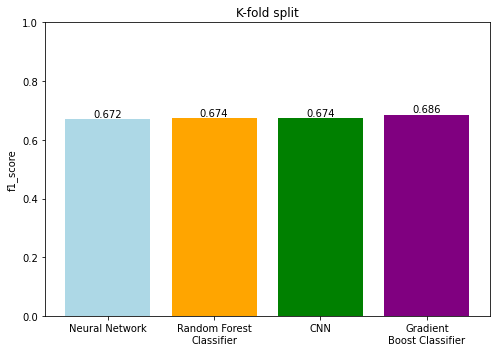

In [ ]:
# Bar graph Split set

colors = ['lightblue','orange','green','purple','grey','olive','red']

plt.figure(figsize=(7,5))
fig = plt.bar(models_name_sort,scores_round_sort,color=colors,width=0.8)


plt.yticks(np.arange(0, 1.2, 0.2))
plt.ylabel('f1_score')

for i in range(len(scores)):
    plt.annotate(str(scores_round_sort[i]), xy=(i,scores_round_sort[i]), ha='center', va='bottom')

plt.title("K-fold split")

plt.tight_layout()

plt.show()